In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from economic_utils import (
    load_and_process_data, 
    calculate_discount_factors,
    find_optimal_c_parameter,
    euler_path_fixed_wages,
    find_duplicate_indices_per_row,
    generate_pattern_array_with_extra_rows,
    generate_rate_combinations,
    plot_comparison_results,
    RISK_AVERSION
)

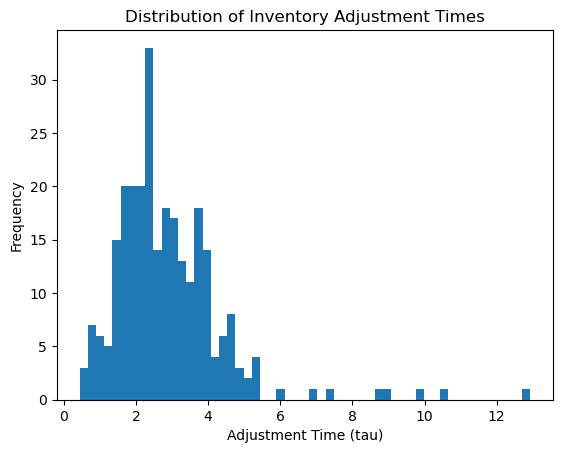

In [2]:
# Economic model constants
INVENTORY_TO_COGS_SCALING = 36.5
DAYS_PER_MONTH = 30
TAX_RATE = 0.1
HISTOGRAM_BINS = 55

# Load and process data
data = pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau = (data['invtCogsRatio'] * INVENTORY_TO_COGS_SCALING / (DAYS_PER_MONTH * TAX_RATE))

# Visualize distribution
import matplotlib.pyplot as plt
plt.hist(data_tau, bins=HISTOGRAM_BINS)
plt.title('Distribution of Inventory Adjustment Times')
plt.xlabel('Adjustment Time (tau)')
plt.ylabel('Frequency')
plt.show()

In [3]:
# Economic model parameters
RISK_AVERSION = 1  # sigma parameter
NOMINAL_INTEREST_RATE = 0.01  # 1% per period
INVENTORY_DURATION = 30  # days
ADJUSTMENT_RATE = 0.9  # proportion of firms adjusting
phi = 0.5
# Calculate discount factors
beta = 1 / (1.0 + NOMINAL_INTEREST_RATE)
beta1 = 1 / (1.0 + NOMINAL_INTEREST_RATE * np.exp(INVENTORY_DURATION / (INVENTORY_TO_COGS_SCALING * ADJUSTMENT_RATE))) 
beta_hh = beta
W = 1  # Wage normalization

sigma = 2

In [4]:
# Economic parameters and constants
EPSILON = 1e-10  # Small value to prevent division by zero
DAYS_PER_MONTH = 30
INVENTORY_ADJUSTMENT = 36.5
TAX_RATE = 0.1

tau_diff = np.zeros((1000, 1))

for i, c in enumerate(np.linspace(0, 0.99, 1000)): 
    # Prevent division by zero in logarithm calculations
    if beta * c <= EPSILON or beta1 * c <= EPSILON:
        tau_diff[i] = np.inf  # Skip problematic values
        continue
        
    # Safe logarithm calculations
    log_beta_c = np.log(beta * c)
    log_beta1_c = np.log(beta1 * c)
    
    N = -(data_tau) - 1 / log_beta_c 
    tau1 = -1 / log_beta_c - N
    tau1[tau1 < 0] = 0     
    
    tau2 = -1 / log_beta1_c - N
    tau2[tau2 < 0] = 0    
    
    tau_diff[i] = np.mean(np.abs(tau1 - tau2))

In [5]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]

In [6]:
c_list = np.linspace(0, 0.99, 1000)
optimal_c_value = c_list[argmins]

In [7]:
optimal_c_value

array([0.9018018])

In [8]:
N = -data_tau - 1/np.log(beta_hh * optimal_c_value) 
tau = -1/np.log(beta_hh * optimal_c_value) - N
tau[tau < 0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil = (beta_hh * optimal_c_value)**tau_ceil * (tau_ceil + N)
tprod_floor = (beta_hh * optimal_c_value)**tau_floor * (tau_floor + N)
tau[(tprod_ceil - tprod_floor) > 0] = tau_ceil[(tprod_ceil - tprod_floor) > 0]
tau[(tprod_ceil - tprod_floor) < 0] = tau_floor[(tprod_ceil - tprod_floor) < 0]
tau[tau < 0] = 0  

tprod = (beta * optimal_c_value)**tau * (tau + N)
tprod_array2 = np.array([tprod])

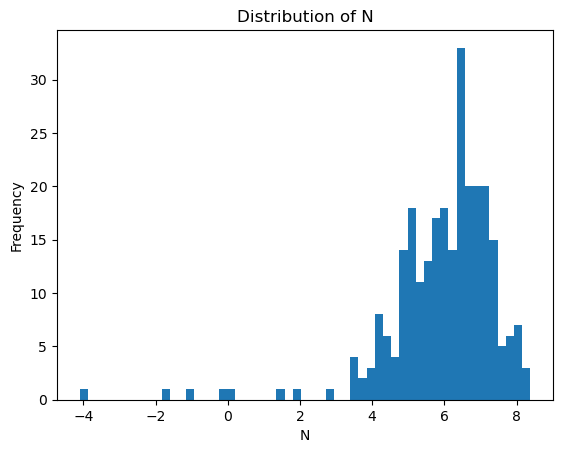

In [9]:
plt.hist(N, bins=HISTOGRAM_BINS )
plt.title('Distribution of N')
plt.xlabel('N')
plt.ylabel('Frequency')
plt.show()  

Mean: 2.87829863692689
Median: 2.579333333333333
Std Dev: 1.5345262363234775
Quantiles (10%,25%,50%,75%,90%): [1.4454     1.9345     2.57933333 3.60133333 4.4311    ]
Fitted lognormal parameters (shape, loc, scale): 0.4946569574967637 0 2.5540666503607437


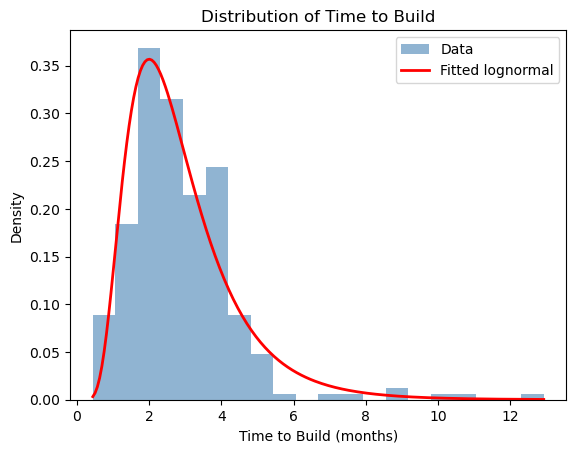

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Example: suppose you have monthly time-to-build data in a CSV
# Replace this with your actual data import
time_to_build =data_tau
# Basic statistics
mean_tau = np.mean(time_to_build)
median_tau = np.median(time_to_build)
std_tau = np.std(time_to_build)
quantiles = np.quantile(time_to_build, [0.1, 0.25, 0.5, 0.75, 0.9])

# Distribution fit (e.g. lognormal if skewed)
shape, loc, scale = stats.lognorm.fit(time_to_build, floc=0)

# Print summary
print("Mean:", mean_tau)
print("Median:", median_tau)
print("Std Dev:", std_tau)
print("Quantiles (10%,25%,50%,75%,90%):", quantiles)
print("Fitted lognormal parameters (shape, loc, scale):", shape, loc, scale)

# Plot histogram and fitted PDF
x = np.linspace(min(time_to_build), max(time_to_build), 200)
pdf_fitted = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

plt.hist(time_to_build, bins=20, density=True, alpha=0.6, color='steelblue', label="Data")
plt.plot(x, pdf_fitted, 'r-', lw=2, label="Fitted lognormal")
plt.xlabel("Time to Build (months)")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Time to Build")
plt.show()


In [11]:
def generate_pattern_array_with_extra_rows(tau):
    """
    Generate a pattern array for productivity shock modeling.
    
    This function creates a matrix pattern used in economic modeling where firms
    face different adjustment costs over time periods.
    
    Parameters:
    -----------
    tau : array-like
        Array of time periods/adjustment delays for different firms
        
    Returns:
    --------
    numpy.ndarray
        Extended pattern matrix with shock adjustment factors
        
    Raises:
    -------
    ValueError
        If tau is empty, contains negative values, or has invalid dimensions
        
    Notes:
    ------
    - Creates n×n pattern where n depends on tau length and range
    - Uses 0.99 as the shock adjustment factor for active periods
    - Adds extra rows for boundary conditions
    """
    # Input validation
    tau = np.asarray(tau)
    if tau.size == 0:
        raise ValueError("tau array cannot be empty")
    if np.any(tau < 0):
        raise ValueError("tau values must be non-negative")
    if not np.isfinite(tau).all():
        raise ValueError("tau must contain only finite values")
        
    # Calculate matrix dimensions based on tau statistics
    n = len(tau) + int(np.min(tau))
    m = int(np.max(tau)) + int(np.min(tau))
    
    max_tau = int(max(tau))
    missing_count = len(set(range(max_tau + 1)) - set(tau))

    # Initialize base matrix with ones (no shock)
    A = np.ones((m + 2, n + missing_count), dtype=float)
    count = 0
    
    # Fill shock adjustment factors (0.99) for active adjustment periods
    for i in range(1, m + 2):
        firms_adjusting = tau[tau == i - 1]
        for j in range(len(firms_adjusting)):
            A[i, n - i - j - count] = 0.97  # Shock adjustment factor
        if len(firms_adjusting) > 1:
            count += len(firms_adjusting) - 1
    
    # Add boundary condition row (all ones)
    row_all_ones = np.ones(n + missing_count, dtype=float)
    A_extended = np.vstack([A, row_all_ones])
    
    # Trim to final dimensions
    A_extended = A_extended[:, 0:n - int(np.min(tau))]

    return A_extended

In [12]:
import numpy as np

def euler_path_fixed_wages(i_path, a_level, beta_hh=1/(1+0.01), sigma=1.0, a_prev=0.0):
    """
    SS-anchored Euler with fixed wages & flexible prices (π_t = -Δa_t).
    i_path: nominal rate (levels), length T
    a_level: log TFP level a_t, length T
    beta_hh: discount factor β
    sigma: inverse IES (Euler slope is 1/σ)
    a_prev: a_{-1} baseline (default 0)
    Returns: (c_hat, pi)
    """
    i_path = np.asarray(i_path, float)
    a_level = np.asarray(a_level, float)
    if i_path.shape != a_level.shape: raise ValueError("Shapes must match.")
    if not (0 < beta_hh < 1): raise ValueError("beta_hh must be in (0,1).")
    if sigma <= 0: raise ValueError("sigma>0 required.")

    T = len(i_path)
    rho = 1.0 / beta_hh - 1.0
    coeff = 1.0 / sigma

    # Proper first differences with initial a_{-1}=a_prev
    da = np.empty(T)
    da[0] = a_level[0] - a_prev
    da[1:] = a_level[1:] - a_level[:-1]
    pi = -da

    # Forward difference for E_t Δa_{t+1}: (da[1:], 0) in deterministic case
    da_fwd = np.r_[da[1:], 0.0]
    # Backward solve for c_hat with terminal c_T=0
    c_hat = np.zeros(T + 1)
    for t in range(T - 1, -1, -1):
        c_hat[t] = c_hat[t+1] - coeff * (i_path[t] + da_fwd[t] - rho)

    return c_hat[:T], pi


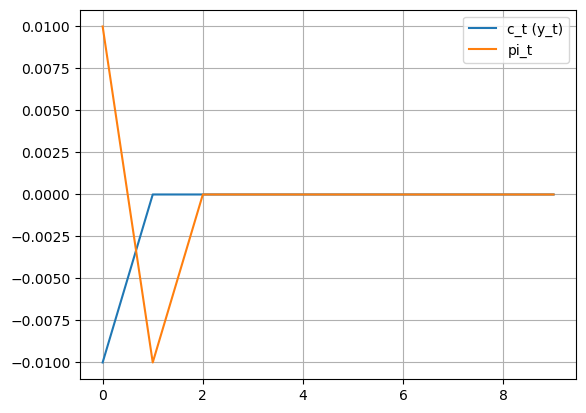

In [13]:


# Example: fixed i=0, expected productivity sequence
T = 10

i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
abar = np.zeros(T)
eps = np.zeros(T)
abar[0] = -0.01

c, pi = euler_path_fixed_wages(i_path, abar)

import matplotlib.pyplot as plt
plt.plot(c, label='c_t (y_t)')
plt.plot(pi, label='pi_t')
plt.legend(); plt.grid(True); plt.show()


In [14]:
import numpy as np
import itertools

sequence_length = 5
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(7776, 5)


In [15]:
import numpy as np

# externals you must define before this block:
# beta_hh, sigma, sequence_length, r_arrange (shape = (size, sequence_length)), T

size = r_arrange.shape[0]

deviation_gap = np.zeros(size)
C_consumption = np.zeros((size, T))
pi_inflation  = np.zeros((size, T))

for k, r_vec in enumerate(r_arrange):              # r_vec shape = (sequence_length,)
    # interest-rate path: baseline rho, add the k-specific shock for first sequence_length periods
    i_path = np.full(T, 0.01, dtype=float)          # levels
    i_path[:sequence_length] = r_vec              # ADDITIVE shock; use '=' if you intend to replace

    # productivity path (example): one-time +1% level at t=0 (adjust to your experiment)
    a_level = np.zeros(T, dtype=float)
    a_level[0] = -0.01

    # solve (adapt to your function signature if different)
    c_hat, pi = euler_path_fixed_wages(i_path, a_level, a_prev=0.0)

    # store results
    C_consumption[k, :] = c_hat
    pi_inflation[k, :]  = pi
    deviation_gap[k]    = np.sum(c_hat**2) + np.sum(pi**2)


In [16]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1036])

In [17]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [18]:
r_arrange[argmins_gap]

array([[0.  , 0.01, 0.01, 0.01, 0.01]])

In [19]:
pi_inflation[matches, :19].T

array([[ 0.01],
       [-0.01],
       [-0.  ],
       [-0.  ],
       [-0.  ],
       [-0.  ],
       [-0.  ],
       [-0.  ],
       [-0.  ],
       [-0.  ]])

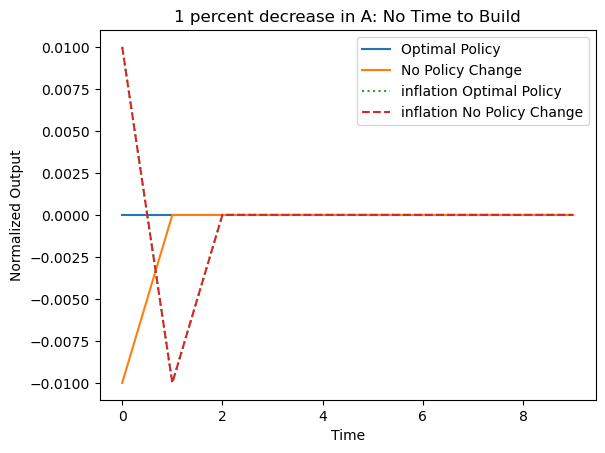

In [20]:
plt.plot( C_consumption[argmins_gap, :19].T, label='Optimal Policy')
plt.plot( C_consumption[matches, :19].T, label='No Policy Change')
plt.plot( pi_inflation[argmins_gap, :19].T, label='inflation Optimal Policy', linestyle='dotted')
plt.plot( pi_inflation[matches, :19].T, label='inflation No Policy Change', linestyle='dashed')

plt.legend()
plt.title('1 percent decrease in A: No Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [21]:
import numpy as np
import itertools

sequence_length = 4
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(1296, 4)


In [22]:
k=0
T=30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
pi_inflation = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 
        

    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[k])
    r = np.asarray(r_arrange[k], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)


    cumprod_ext = np.ones((30,31))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    beta_prod = cumprod_ext[:,tvals] 

    tprod_array = np.array((beta_prod * optimal_c_value) * (((tvals + N_array))*np.ones((30,269)) ))
    prod_shock = np.ones((30,269))
    A = generate_pattern_array_with_extra_rows(tau)
    prod_shock[0:15] =A[1:]
    inside = (prod_shock*tprod_array)**(sigma-1)
    A_prod = np.sum( inside,axis = 1)**(1/(sigma-1))

    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[k]  
    abar = np.log(A_prod) - np.log(A_prod)[-1]  # log productivity sequence

    c_hat, pi = euler_path_fixed_wages(i_path, abar, a_prev=0)
    deviation_gap[k] = np.sum((c_hat )**2)  + np.sum((pi)**2)
    C_consumption[k, :len(c_hat )] = c_hat
    pi_inflation[k, :len(pi)] = pi
    k = k+1

In [23]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [24]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1240])

In [25]:
r_arrange[argmins_gap]

array([[0.0125, 0.01  , 0.005 , 0.01  ]])

In [26]:
target = np.array([0.01, 0.01  , 0.005, 0.01  ])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

In [30]:
target2 =np.array([[0.  , 0.01, 0.01, 0.01]])
matches3 = np.all(np.isclose(r_arrange, target2), axis=1)

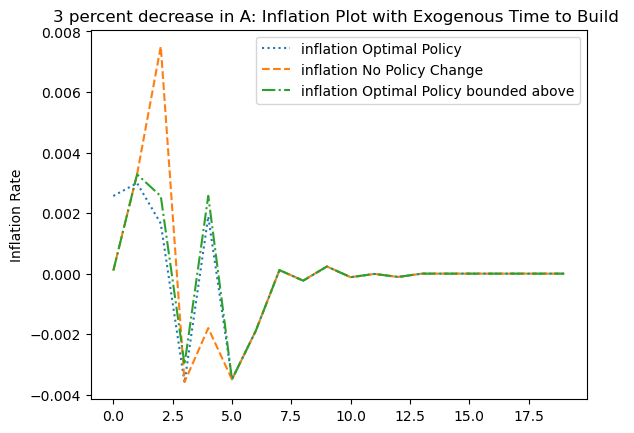

In [31]:
plt.plot( pi_inflation[argmins_gap, :20].T, label='inflation Optimal Policy', linestyle='dotted')
plt.plot( pi_inflation[matches, :20].T, label='inflation No Policy Change', linestyle='dashed')
plt.plot( pi_inflation[matches2, :20].T, label='inflation Optimal Policy bounded above', linestyle='dashdot')
plt.title('3 percent decrease in A: Inflation Plot with Exogenous Time to Build ')
plt.ylabel('Inflation Rate')
plt.legend()
plt.show()

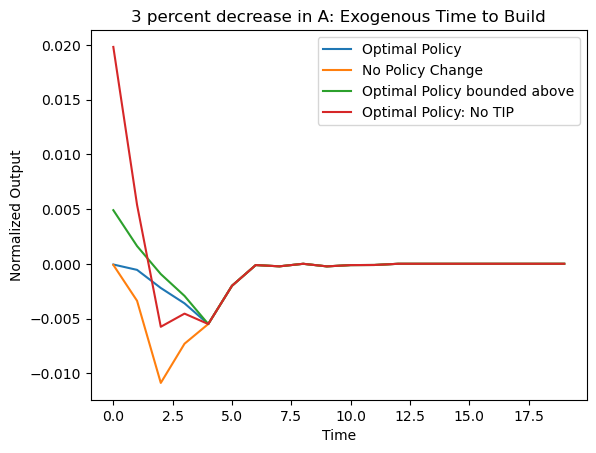

In [32]:
plt.plot( C_consumption[argmins_gap, :20].T, label='Optimal Policy')
plt.plot( C_consumption[matches, :20].T, label='No Policy Change' )
plt.plot( C_consumption[matches2, :20].T, label='Optimal Policy bounded above' )
plt.plot( C_consumption[matches3, :20].T, label='Optimal Policy: No TIP' )

plt.legend()
plt.title('3 percent decrease in A: Exogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [33]:
def find_duplicate_indices_per_row(arr, tol=0.0):
    """
    Find indices of duplicate values within each row of a 2D array.
    
    This function identifies which column indices contain duplicate values
    within each row, useful for handling timing conflicts in economic models
    where multiple firms might adjust prices simultaneously.
    
    Parameters:
    -----------
    arr : numpy.ndarray
        2D array of shape (R, C) to search for duplicates
    tol : float, optional (default=0.0)
        Tolerance for considering values equal
        - If 0.0: exact match required
        - If > 0.0: values within tolerance are considered duplicates
        
    Returns:
    --------
    list of lists
        For each row, returns list of column indices that contain duplicates
        Length equals number of rows in input array
        
    Examples:
    ---------
    >>> arr = np.array([[1, 2, 1], [3, 3, 4]])
    >>> find_duplicate_indices_per_row(arr)
    [[0, 2], [0, 1]]  # Row 0: cols 0,2 both have value 1
                      # Row 1: cols 0,1 both have value 3
    """
    dup_indices = []
    
    for row in arr:
        if tol > 0:
            # Tolerance-based matching for floating point values
            idxs = []
            for i in range(len(row)):
                for j in range(i + 1, len(row)):
                    if abs(row[i] - row[j]) <= tol:
                        idxs.extend([i, j])
            dup_indices.append(sorted(set(idxs)))
        else:
            # Exact matching using numpy unique
            vals, inv, counts = np.unique(row, return_inverse=True, return_counts=True)
            duplicate_vals = np.where(counts > 1)[0]  # Values that appear more than once
            duplicate_cols = np.where(np.isin(inv, duplicate_vals))[0]  # Column indices of duplicates
            dup_indices.append(duplicate_cols.tolist())
    
    return dup_indices

In [34]:
rate_arrangement_idx = 0
T = 30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
pi_inflation = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tau_values = tau_int.to_numpy()

for rate_combo in r_arrange: 
    interest_rate_list = np.ones((T, T)) * 0.01
    # Start with all rows = base

    num_periods = len(r_arrange[rate_arrangement_idx])
    rates = np.asarray(r_arrange[rate_arrangement_idx], dtype=float)
    fill_value = 0.01

    arr2d = np.full((num_periods, num_periods), fill_value, dtype=float)

    # Fill each row with the backward-looking rates
    for period_idx in range(num_periods):
        arr2d[period_idx, :period_idx+1] = rates[period_idx::-1]

    # Put into big matrix
    interest_rate_list[0:num_periods, :num_periods] = arr2d

    # Compute beta (discount factor)
    beta = 1.0 / (1.0 + interest_rate_list) * optimal_c_value

    cumprod_ext = np.ones((T, T+1))
    cumprod_ext[:, 1:] = np.cumprod(beta, axis=1)
    tau_list = np.linspace(0, T, T+1)
    time_list_stuff = tau_list * np.ones((T, T+1))
    tprod = (cumprod_ext)[:, :, None] * (time_list_stuff[:, :, None] + np.array(N)[None, None, :])
    tprod_array = np.array(tprod)

    # idx_max will be (30, 269), giving the best column index for each (i, k)
    idx_max = np.argmax(tprod_array, axis=1)  # axis=1 corresponds to the 31 columns

    # Now gather the max values
    max_vals = np.max(tprod, axis=1)    # shape (30, 269)

    tau_best = idx_max

    time_period = np.linspace(0, 29, 30) * np.ones_like(tau_best).T
    tau_timing = tau_best.T + time_period
    Productivity = np.zeros((len(tau_timing), 30))
    Productivity = max_vals.T
    shock_adjustment = 0.97

    duplicates = find_duplicate_indices_per_row(tau_timing)
    for firm_idx in range(len(tau_timing)):
        time_idx = 0
        for period in tau_timing[firm_idx, tau_timing[firm_idx, :] < 30]:
            if time_idx in duplicates[firm_idx]:
                for duplicate_idx in duplicates[firm_idx]:
                    if tau_timing[firm_idx, duplicate_idx] == period:
                        if time_idx == 0:
                            is_better = shock_adjustment * max_vals[time_idx, firm_idx] > max_vals[duplicate_idx, firm_idx]
                            if is_better:
                                Productivity[firm_idx, int(period)] = shock_adjustment * max_vals[time_idx, firm_idx]
                                Productivity[firm_idx, int(tau_timing[firm_idx, duplicate_idx])] = 0
                            else:
                                Productivity[firm_idx, int(period)] = 0
                        else:
                            is_better = max_vals[time_idx, firm_idx] > max_vals[duplicate_idx, firm_idx]
                            if is_better:
                                Productivity[firm_idx, int(tau_timing[firm_idx, duplicate_idx])] = 0
                            else:
                                Productivity[firm_idx, int(period)] = 0
            else:
                if time_idx == 0:
                    Productivity[firm_idx, int(period)] = shock_adjustment * max_vals[time_idx, firm_idx]
            time_idx += 1
    
    A_prod = np.sum((Productivity)**(sigma-1), axis=0)**(1/(sigma-1))
    
    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[rate_arrangement_idx]  
    abar = np.log(A_prod) - np.log(A_prod)[-1]  # log productivity sequence

    c_hat, pi = euler_path_fixed_wages(i_path, abar, a_prev=0)
    deviation_gap[rate_arrangement_idx] = np.sum((c_hat )**2) + np.sum((pi)**2)
    C_consumption[rate_arrangement_idx, :len(c_hat)] = c_hat
    pi_inflation[rate_arrangement_idx, :len(pi)] = pi
    rate_arrangement_idx += 1

In [35]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [36]:
target2 =np.array([[0.  , 0.01, 0.01, 0.01]])
matches3 = np.all(np.isclose(r_arrange, target2), axis=1)

In [37]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1036])

In [38]:
r_arrange[argmins_gap]

array([[0.01, 0.01, 0.01, 0.01]])

In [39]:
target = np.array([0.01, 0.01  , 0.01, 0.0075  ])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

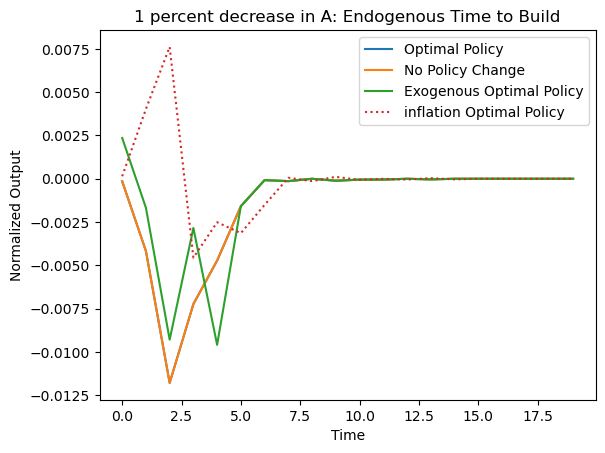

In [42]:
plt.plot( C_consumption[argmins_gap, :20].T, label='Optimal Policy')
plt.plot( C_consumption[matches, :20].T, label='No Policy Change' )
plt.plot( C_consumption[matches2, :20].T, label='Exogenous Optimal Policy' )

plt.plot( pi_inflation[argmins_gap, :20].T, label='inflation Optimal Policy', linestyle='dotted')

plt.legend()
plt.title('1 percent decrease in A: Endogenous Time to Build')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [79]:
import numpy as np
import itertools

sequence_length = 5
r_choice = np.linspace(0.005, 0.01, 3)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(243, 5)


In [80]:
rate_arrangement_idx = 0
T = 30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
pi_inflation = np.zeros((size, 30))
tau_values_list = np.zeros((T, 269, size))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tau_values = tau_int.to_numpy()

for rate_combo in r_arrange: 
    interest_rate_list = np.ones((T, T)) * 0.01
    # Start with all rows = base

    num_periods = len(r_arrange[rate_arrangement_idx])
    rates = np.asarray(r_arrange[rate_arrangement_idx], dtype=float)
    fill_value = 0.01

    arr2d = np.full((num_periods, num_periods), fill_value, dtype=float)

    # Fill each row with the backward-looking rates
    for period_idx in range(num_periods):
        arr2d[period_idx, :period_idx+1] = rates[period_idx::-1]

    # Put into big matrix
    interest_rate_list[0:num_periods, :num_periods] = arr2d

    # Compute beta (discount factor)
    beta = 1.0 / (1.0 + interest_rate_list) * optimal_c_value

    cumprod_ext = np.ones((T, T+1))
    cumprod_ext[:, 1:] = np.cumprod(beta, axis=1)
    tau_list = np.linspace(0, T, T+1)
    time_list_stuff = tau_list * np.ones((T, T+1))
    # Shock N term by 0.99 only in first time period       N_shocked = np.array(N)[None, None, :]
    N_shocked = np.array(N)[None, None, :]
    N_first_period = np.array(N)[None, None, :]
    N_term = np.where(time_list_stuff[:, :, None] == 0,
       N_first_period, N_shocked)
    N_term[0,:,:] = N_term[0,:,:] * 0.99  # Shock only first row

    tprod = (cumprod_ext)[:, :, None] * (time_list_stuff[:, :, None] + N_term)
    tprod_array = np.array(tprod)

    # idx_max will be (30, 269), giving the best column index for each (i, k)
    idx_max = np.argmax(tprod_array, axis=1)  # axis=1 corresponds to the 31 columns

    # Now gather the max values
    max_vals = np.max(tprod, axis=1)    # shape (30, 269)

    tau_best = idx_max

    time_period = np.linspace(0, 29, 30) * np.ones_like(tau_best).T
    tau_timing = tau_best.T + time_period
    Productivity = np.zeros((len(tau_timing), 30))
    Productivity = max_vals.T
    shock_adjustment = 1

    duplicates = find_duplicate_indices_per_row(tau_timing)
    for firm_idx in range(len(tau_timing)):
        time_idx = 0
        for period in tau_timing[firm_idx, tau_timing[firm_idx, :] < 30]:
            if time_idx in duplicates[firm_idx]:
                for duplicate_idx in duplicates[firm_idx]:
                    if tau_timing[firm_idx, duplicate_idx] == period:
                        if time_idx == 0:
                            is_better = shock_adjustment * max_vals[time_idx, firm_idx] > max_vals[duplicate_idx, firm_idx]
                            if is_better:
                                Productivity[firm_idx, int(period)] = shock_adjustment * max_vals[time_idx, firm_idx]
                                Productivity[firm_idx, int(tau_timing[firm_idx, duplicate_idx])] = 0
                            else:
                                Productivity[firm_idx, int(period)] = 0
                        else:
                            is_better = max_vals[time_idx, firm_idx] > max_vals[duplicate_idx, firm_idx]
                            if is_better:
                                Productivity[firm_idx, int(tau_timing[firm_idx, duplicate_idx])] = 0
                            else:
                                Productivity[firm_idx, int(period)] = 0
            else:
                if time_idx == 0:
                    Productivity[firm_idx, int(period)] = shock_adjustment * max_vals[time_idx, firm_idx]
            time_idx += 1
    
    A_prod = np.sum((Productivity)**(sigma-1), axis=0)**(1/(sigma-1))
    
    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[rate_arrangement_idx]  
    abar = np.log(A_prod) - np.log(A_prod)[-1]  # log productivity sequence

    c_hat, pi = euler_path_fixed_wages(i_path, abar, a_prev=0)
    deviation_gap[rate_arrangement_idx] = np.sum((c_hat )**2) + np.sum((pi)**2)
    C_consumption[rate_arrangement_idx, :len(c_hat)] = c_hat
    pi_inflation[rate_arrangement_idx, :len(pi)] = pi
    tau_values_list[:,:,rate_arrangement_idx] = tau_best
    rate_arrangement_idx += 1

In [81]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([240])

In [82]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [83]:
r_arrange[argmins_gap]

array([[0.01 , 0.01 , 0.01 , 0.01 , 0.005]])

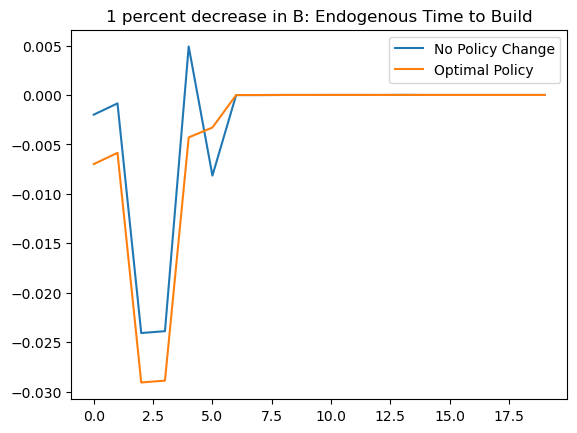

In [84]:
plt.plot( C_consumption[argmins_gap, :20].T, label='No Policy Change')
plt.plot( C_consumption[matches, :20].T, label='Optimal Policy')

plt.legend()
plt.title('1 percent decrease in B: Endogenous Time to Build')
plt.show()

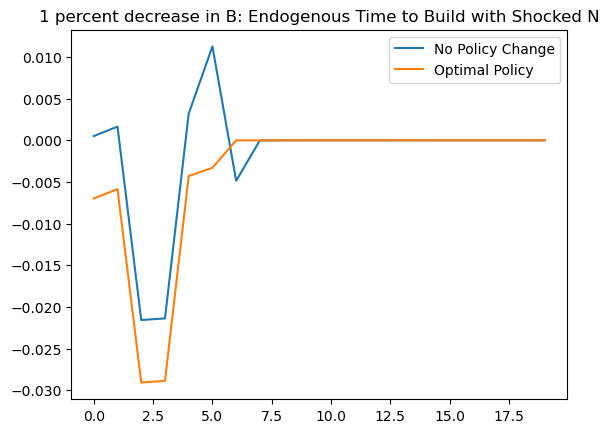

In [44]:
plt.plot( C_consumption[argmins_gap, :20].T, label='No Policy Change')
plt.plot( C_consumption[matches, :20].T, label='Optimal Policy')

plt.legend()
plt.title('1 percent decrease in B: Endogenous Time to Build with Shocked N')
plt.show()